In [66]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

import lsst.ip.diffim as ipDiffim

In [67]:
import diffimTests as dit
#reload(dit)

testObj = dit.DiffimTest(n_sources=2000, verbose=True, sourceFluxRange=(2000., 60000.), # psf_yvary_factor=0.5, 
                         psfSize=13)
res = testObj.runTest(spatialKernelOrder=2)
print res

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: -0.0 -0.0
Variable source: 2 461.346891785 121.823858741 0 620.0
Variable source: 5 431.749372598 424.439040438 0 620.0
Variable source: 7 357.85043881 75.4457595283 0 620.0
Variable source: 0 259.107823309 406.055880733 0 620.0
Variable source: 8 216.433038668 391.667604668 0 620.0
Variable source: 10 329.094426972 369.475075997 0 620.0
Variable source: 6 217.680749125 375.50439259 0 620.0
Variable source: 9 210.092854051 146.317412504 0 620.0
Variable source: 4 324.98682298 272.012901819 0 620.0
Variable source: 11 232.560730746 217.069065405 0 620.0
{'ZOGY': {'FP': 0, 'FN': 10, 'TP': 0}, 'ALstack': {'FP': 1, 'FN': 9, 'TP': 1}, 'SZOGY': {'FP': 0, 'FN': 10, 'TP': 0}, 'ALstack_decorr': {'FP': 0, 'FN': 10, 'TP': 0}}


A&L(dec): stats(mean=0.11269277, stdev=25.474852, min=-169.55235, max=168.5311)
ZOGY: stats(mean=-0.036375551563589688, stdev=25.398023255307006, min=-180.38529588799324, max=139.30260321564612)
A&L(dec) - ZOGY: stats(mean=0.12922809765755966, stdev=1.9845202895926948, min=-43.355658938771619, max=57.62856624340985)
A&L(dec) - A&L: stats(mean=-0.027730342, stdev=7.0030599, min=-45.383652, max=43.981781)


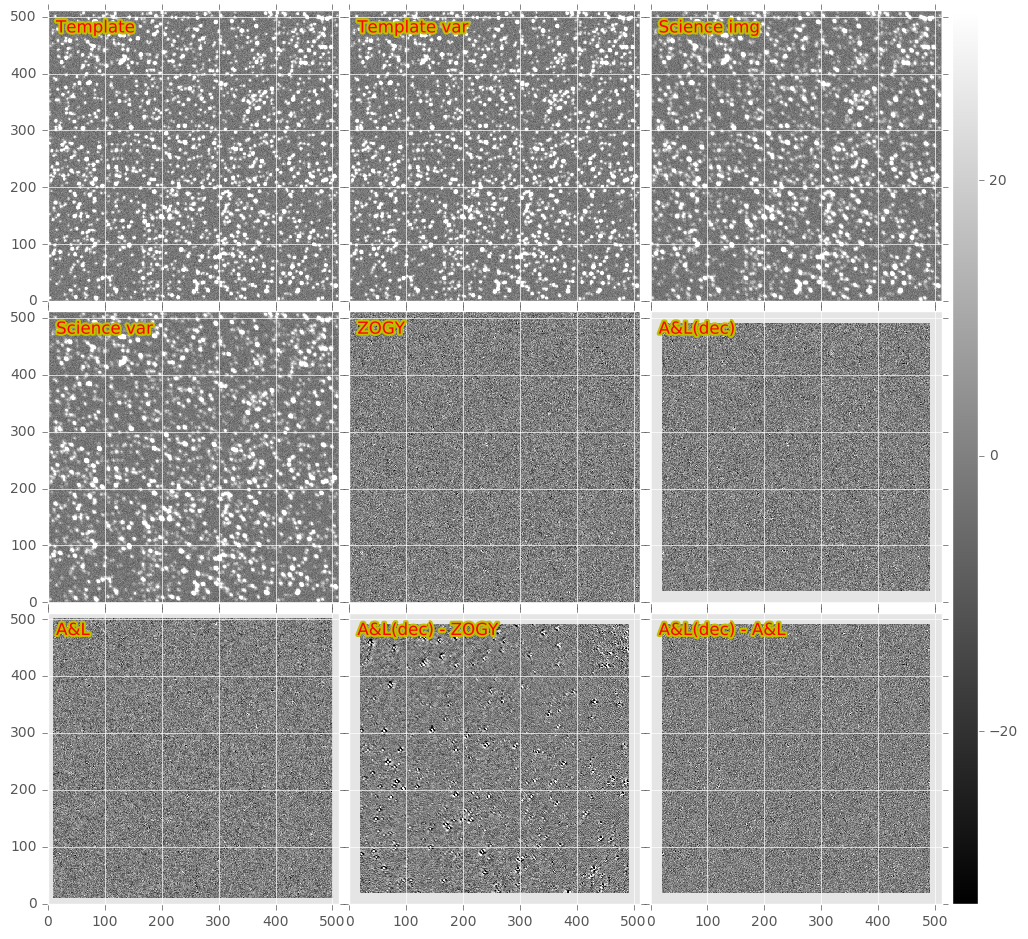

In [68]:
#dit.plotImageGrid((testObj.im1.im, testObj.im2.im), imScale=8)
testObj.doPlot(imScale=4);

In [99]:
exposure = testObj.im2.asAfwExposure()
res = dit.tasks.doMeasurePsf(exposure, spatialOrder=1)
psf = res.psf
exposure.setPsf(psf)

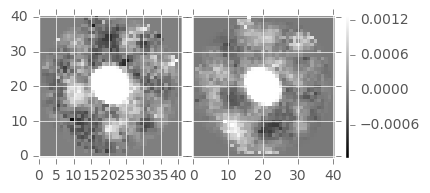

In [80]:
import lsst.afw.geom as afwGeom
dit.plotImageGrid((psf.computeImage(afwGeom.Point2D(20., 20.)), psf.computeImage(afwGeom.Point2D(500.,500.))))

In [100]:
template = testObj.im1.asAfwExposure()
res = dit.tasks.doMeasurePsf(template, spatialOrder=1)
psf = res.psf
template.setPsf(psf)

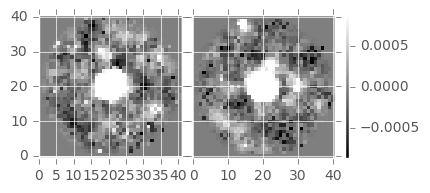

In [82]:
dit.plotImageGrid((psf.computeImage(afwGeom.Point2D(20., 20.)), psf.computeImage(afwGeom.Point2D(500.,500.))))

In [83]:
print testObj.im1.psf.shape, testObj.im2.psf.shape
print testObj.im1.asAfwExposure().getPsf().computeImage().getArray().shape
print testObj.im2.asAfwExposure().getPsf().computeImage().getArray().shape
print exposure.getPsf().computeImage().getArray().shape
print template.getPsf().computeImage().getArray().shape

print testObj.im1.sig, testObj.im2.sig

(25, 25) (25, 25)
(25, 25)
(25, 25)
(41, 41)
(41, 41)
17.5523693804 17.7743710079


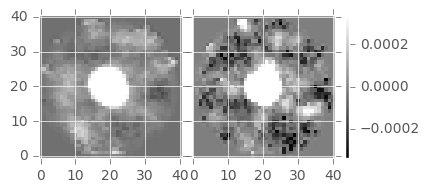

In [84]:
dit.plotImageGrid((exposure.getPsf().computeImage().getArray(), template.getPsf().computeImage().getArray()))

OK, let's try a spatially-varying ZOGY! But without correctly setting the (spatially varying) PSF of the diffim.

In [88]:
import lsst.pex.config as pexConfig
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom

class ZogyGridSubtaskConfig(ipDiffim.ImageGridSubtaskConfig):
    pass

class ZogyGridSubtask(ipDiffim.ImageGridSubtask):
    ConfigClass = ZogyGridSubtaskConfig
    _DefaultName = 'ip_diffim_ZogyGridSubtask'
    
    def __init__(self, *args, **kwargs):
        ipDiffim.ImageGridSubtask.__init__(self, *args, **kwargs)
        
    def run(self, subExp, expandedSubExp, fullBBox, **kwargs):
        bbox = subExp.getBBox()
        center = ((bbox.getBeginX() + bbox.getEndX()) / 2., (bbox.getBeginY() + bbox.getEndY()) / 2.)
        
        # Psf and image for science img (index 2)
        subExp2 = subExp
        psf2 = subExp.getPsf().computeImage(afwGeom.Point2D(center[0], center[1])).getArray()
        subim2 = expandedSubExp.getMaskedImage()
        subarr2 = subim2.getImage().getArray()
        subvar2 = subim2.getVariance().getArray()
        sig2 = np.sqrt(dit.computeClippedImageStats(subvar2).mean)
        
        # Psf and image for template img (index 1)
        template = kwargs.get('template')
        subExp1 = afwImage.ExposureF(template, expandedSubExp.getBBox())
        psf1 = template.getPsf().computeImage(afwGeom.Point2D(center[0], center[1])).getArray()
        subim1 = subExp1.getMaskedImage()
        subarr1 = subim1.getImage().getArray()
        subvar1 = subim1.getVariance().getArray()
        sig1 = np.sqrt(dit.computeClippedImageStats(subvar1).mean)
        
        #shape2 = subExp2.getPsf().computeShape(afwGeom.Point2D(center[0], center[1]))
        #shape1 = subExp1.getPsf().computeShape(afwGeom.Point2D(center[0], center[1]))
        #print shape2, shape1
        
        psf1b = psf1; psf2b = psf2
        if psf1.shape[0] == 41:   # it's a measured psf (hack!)
            psf1b = psf1.copy()
            psf1b[psf1b < 0] = 0
            psf1b[0:10,0:10] = psf1b[31:41,31:41] = 0
            psf1b /= psf1b.sum()

            psf2b = psf2.copy()
            psf2b[psf2b < 0] = 0
            psf2b[0:10,0:10] = psf2b[31:41,31:41] = 0
            psf2b /= psf2b.sum()

        # from diffimTests.diffimTests ...
        padSize0 = subarr1.shape[0]//2 - psf1.shape[0]//2
        padSize1 = subarr1.shape[1]//2 - psf1.shape[1]//2
        # Hastily assume the image is even-sized and the psf is odd... and that the two images
        #   and psfs have the same dimensions!
        psf1 = np.pad(psf1b, ((padSize0, padSize0-1), (padSize1, padSize1-1)), mode='constant',
                      constant_values=0)
        psf2 = np.pad(psf2b, ((padSize0, padSize0-1), (padSize1, padSize1-1)), mode='constant',
                      constant_values=0)
        if psf1.shape[0] > subarr1.shape[0]:
            psf1 = psf1[:-1, :]
            psf2 = psf2[:-1, :]
        elif psf1.shape[0] < subarr1.shape[0]:
            psf1 = np.pad(psf1, ((0, 1), (0, 0)), mode='constant', constant_values=0)
            psf2 = np.pad(psf2, ((0, 1), (0, 0)), mode='constant', constant_values=0)
        if psf1.shape[1] > subarr1.shape[1]:
            psf1 = psf1[:, :-1]
            psf2 = psf2[:, :-1]
        elif psf1.shape[1] < subarr1.shape[1]:
            psf1 = np.pad(psf1, ((0, 0), (0, 1)), mode='constant', constant_values=0)
            psf2 = np.pad(psf2, ((0, 0), (0, 1)), mode='constant', constant_values=0)
        psf1 /= psf1.sum()
        psf2 /= psf2.sum()
        
        #shape2 = dit.arrayToAfwPsf(psf2).computeShape(afwGeom.Point2D(center[0], center[1]))
        #shape1 = dit.arrayToAfwPsf(psf1).computeShape(afwGeom.Point2D(center[0], center[1]))
        #print center, shape2, shape1

        D_zogy, var_zogy = dit.zogy.performZOGY(subarr1, subarr2,
                                                subvar1, subvar2,
                                                psf1, psf2, 
                                                sig1=sig1, sig2=sig2)
        
#         D_zogy, var_zogy = dit.zogy.performZOGYImageSpace(subarr1, subarr2,
#                                                           subvar1, subvar2,
#                                                           psf1, psf2, 
#                                                           sig1=sig1, sig2=sig2, padSize=15)
        tmpExp = expandedSubExp.clone()
        tmpIM = tmpExp.getMaskedImage()
        tmpIM.getImage().getArray()[:, :] = D_zogy
        tmpIM.getVariance().getArray()[:, :] = var_zogy
        # need to eventually compute diffim PSF and set it here.
        out = afwImage.ExposureF(tmpExp, subExp.getBBox())
                
        #print template
        #img += 10.
        return out
    
class ZogyGridderConfig(ipDiffim.ImageGridderConfig):
    gridSubtask = pexConfig.ConfigurableField(
        doc='Zogy subtask to run on each sub-image',
        target=ZogyGridSubtask
    )

In [104]:
config = ZogyGridderConfig()
config.gridStepX = config.gridStepY = 5
config.gridSizeX = config.gridSizeY = 7
config.reduceOperation = 'average'
task = ipDiffim.ImageGridderTask(config=config)

newExp = task.run(exposure, template=template)

stats(mean=0.92826474, stdev=29.78738, min=-86.0, max=2411.0)
stats(mean=-6.1129341, stdev=27.556818, min=-493.4566, max=331.56662)
stats(mean=13.502971, stdev=40.021111, min=-148.48798, max=2227.0818)


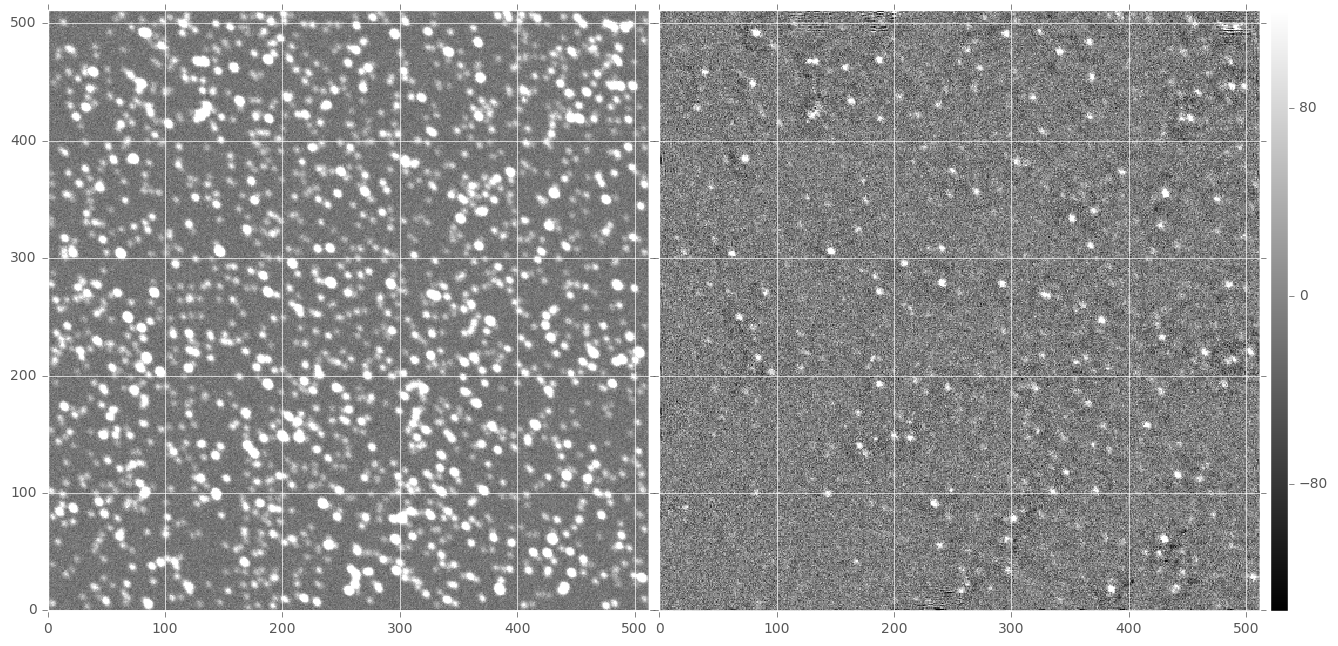

In [105]:
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(newExp.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray()-newExp.getMaskedImage().getImage().getArray())
dit.plotImageGrid((exposure.getMaskedImage().getImage(), newExp.getMaskedImage().getImage()), imScale=8)

### re-do without measured psfs...

In [106]:
template2 = testObj.im1.asAfwExposure()
exposure2 = testObj.im2.asAfwExposure()

#config = ZogyGridderConfig()
#config.gridStepX = config.gridStepY = 4
#config.gridSizeX = config.gridSizeY = 5
#config.reduceOperation = 'average'
#task = ipDiffim.ImageGridderTask(config=config)

newExp = task.run(exposure2, template=template2)

stats(mean=0.92826474, stdev=29.78738, min=-86.0, max=2411.0)
stats(mean=-0.045684014, stdev=25.501608, min=-600.46796, max=165.04492)
stats(mean=3.4942539, stdev=36.916683, min=-121.36828, max=2456.4775)


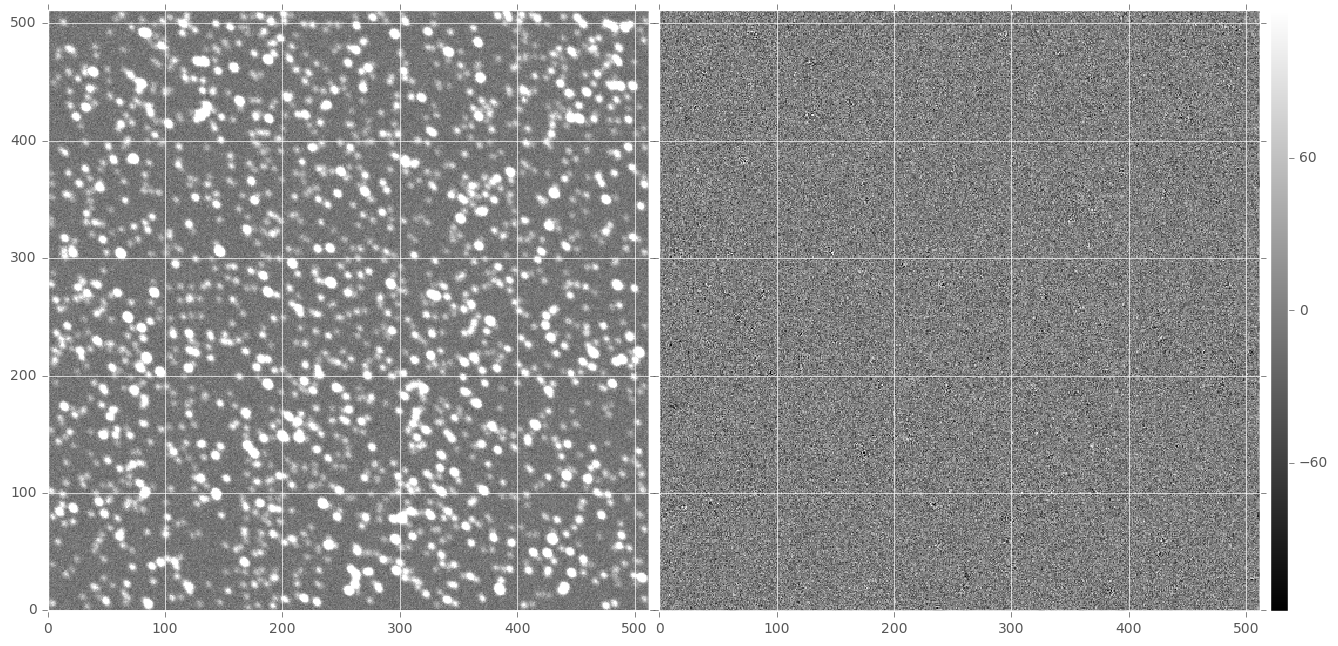

In [107]:
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(newExp.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray()-newExp.getMaskedImage().getImage().getArray())
dit.plotImageGrid((exposure.getMaskedImage().getImage(), newExp.getMaskedImage().getImage()), imScale=8)

stats(mean=-0.046736940040496687, stdev=27.507723677126361, min=-601.48154593148467, max=174.9537043742622)


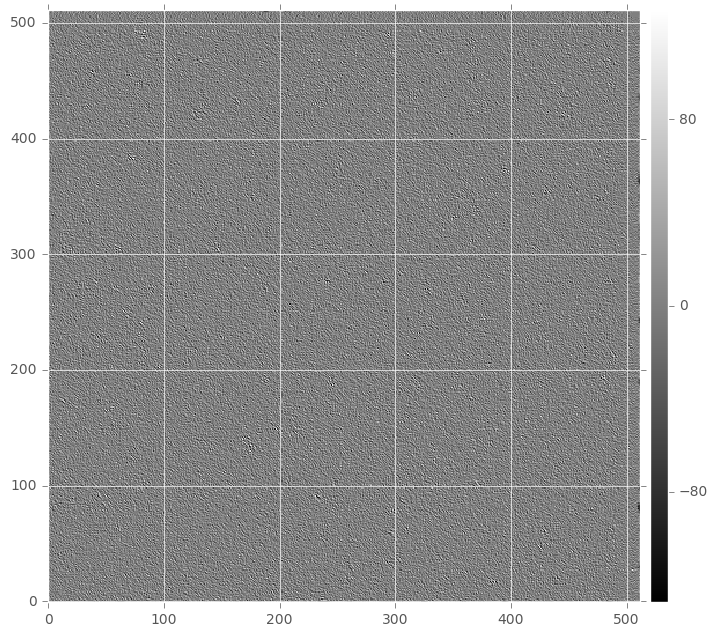

In [108]:
print dit.computeClippedImageStats(newExp.getMaskedImage().getImage().getArray() - testObj.D_ZOGY.im)
dit.plotImageGrid((newExp.getMaskedImage().getImage().getArray() - testObj.D_ZOGY.im,), imScale=8)

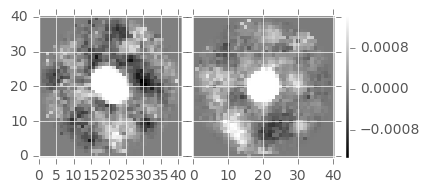

In [36]:
psf = newExp.getPsf()
dit.plotImageGrid((psf.computeImage(afwGeom.Point2D(20., 20.)), psf.computeImage(afwGeom.Point2D(500.,500.))))